# Semantic Segmentation of Nucleii

* This is an example of semantic segmentaton using the the Data Science Bowl 2018 dataset; cell nucleii images are labeled using image masks.
* While the competition was looking for instance segmentation (each nucleii labeled seperately), here we tackle the less complex problem of semantic segmentation.
* Using the TensorFlow/Keras framework, we train a U-Net neural network to classify the areas of the images that are nucleii, essentially classifying each pixel.

In [ ]:
import os
import multiprocessing
import glob
import datetime
import random
import time
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
import PIL
from PIL import Image
from PIL import ImageChops
from PIL import ImageOps
import pandas as pd
from IPython.display import FileLink
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers.core import Activation, SpatialDropout2D
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.models import   Model
from tensorflow.python.keras.utils import conv_utils
from tensorflow.keras.layers import Activation,Conv2D,MaxPooling2D,BatchNormalization,Input,DepthwiseConv2D,add,Dropout,AveragePooling2D,Concatenate

# 1. Setup Constants and Data, Start TensorBoard

In [ ]:
TRAIN_HOME_DIR = "/kaggle/working/stage1_train"
TEST_HOME_DIR = "/kaggle/working/stage1_test"
MODEL_CHECKPOINT_NAME = "/kaggle/working/nucleii_segmentation.h5"
TB_LOGDIR = "/kaggle/working/tensorboardlogs"
TRAIN_SPLIT = 0.8
IMG_SIZE = (512, 512)
NUM_CLASSES = 2
BATCH_SIZE = 4
EPOCHS = 50
AUGMENTATION_ON = False

In [ ]:
# Unzip the training data, download and unzip ngrok to run TensorBoard later
!mkdir -p /kaggle/working/stage1_train && unzip -n -q /kaggle/input/data-science-bowl-2018/stage1_train.zip -d /kaggle/working/stage1_train
# !mkdir -p /kaggle/working/stage1_test  && unzip -n -q /kaggle/input/data-science-bowl-2018/stage1_test.zip -d /kaggle/working/stage1_test
!wget -Nq https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip; unzip -n -q ngrok-stable-linux-amd64.zip -d /kaggle/working

In [ ]:
## Start Up TensorBoard and ngrok
# Start TensorBoard, `ngrok` opens a tunnel to our Kaggle session to connect to TensorBoard
# A clickable URL appears in the output below

pool = multiprocessing.Pool(processes = 10)
results_of_processes = [pool.apply_async(os.system, args=(cmd, ), callback = None )
                        for cmd in [
                        f"tensorboard --logdir {TB_LOGDIR} --host 0.0.0.0 --port 6006 &",
                        "./ngrok http 6006 &"
                        ]]
time.sleep(2)
!curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://f432ebf52086.ngrok.io


# 2. Define Functions

In [ ]:
def generate_combined_mask(home_dir):
    path_list = [d.path for d in os.scandir(home_dir) if d.is_dir()]
    for img_path in tqdm(iterable=path_list, desc="Processing mask files"):
        searchpath = os.path.join(img_path, "masks", "*.png")
        masklist = glob.glob(searchpath)
        firstmask = Image.open(masklist[0], 'r')
        img_w, img_h = firstmask.size
        background_image = Image.new('L', (img_w, img_h), 0)
        for m in masklist:
            background_image = ImageChops.lighter(background_image, Image.open(m))
        new_mask_dir = os.path.join(img_path, "masks2")
        os.makedirs(new_mask_dir, exist_ok=True)
        new_mask_path = os.path.join(new_mask_dir, "newmask.png")
        background_image.save(new_mask_path)
    image_list = [f.path for i in path_list for f in os.scandir(os.path.join(i, "images")) if f.is_file()]
    masks_list = [f.path for i in path_list for f in os.scandir(os.path.join(i, "masks2")) if f.is_file()]
    return image_list, masks_list

class Nucleii(keras.utils.Sequence):
    # Helper to turn images into Sequence object for TF model
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths, img_dtype="float32", tgt_dtype="uint8"):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.img_dtype = img_dtype
        self.tgt_dtype = tgt_dtype

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        # Returns tuple (input, target) correspond to batch #idx.
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype=self.img_dtype)
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype=self.tgt_dtype)
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            tgt_array = np.array(img) / 255
            y[j] = np.expand_dims(tgt_array, 2)
        return x, y

def image_and_mask_generator(image_list, masks_list, generator_args, image_size, batch_size):
    generator_list = []
    seed = 1
    colormode = {0:"rgb", 1:"grayscale"}
    for i, j in enumerate([image_list, masks_list]):
        dtype = ("uint8" if i==1 else None) # for mask dtype
        generator_args["dtype"] = dtype
        datagen = ImageDataGenerator(**generator_args)
        generator = datagen.flow_from_dataframe(
        dataframe=pd.DataFrame(j),
        directory=None,
        x_col=0,
        target_size=image_size,
        color_mode=colormode[i],
        class_mode=None,
        batch_size=batch_size,
        seed=seed)
        generator_list.append(generator)
    return zip(*generator_list)


In [ ]:
"""
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###
    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    previous_block_activation = x  # Set aside residual

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model
"""    


'\ndef get_model(img_size, num_classes):\n    inputs = keras.Input(shape=img_size + (3,))\n\n    ### [First half of the network: downsampling inputs] ###\n    # Entry block\n    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)\n    x = layers.BatchNormalization()(x)\n    x = layers.Activation("relu")(x)\n\n    previous_block_activation = x  # Set aside residual\n\n    # Blocks 1, 2, 3 are identical apart from the feature depth.\n    for filters in [64, 128, 256]:\n        x = layers.Activation("relu")(x)\n        x = layers.SeparableConv2D(filters, 3, padding="same")(x)\n        x = layers.BatchNormalization()(x)\n\n        x = layers.Activation("relu")(x)\n        x = layers.SeparableConv2D(filters, 3, padding="same")(x)\n        x = layers.BatchNormalization()(x)\n\n        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)\n\n        # Project residual\n        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(\n            previous_block_activation\n 

In [ ]:
# This is a bug fix for the Keras MeanIoU metric 
# From https://stackoverflow.com/questions/61824470/dimensions-mismatch-error-when-using-tf-metrics-meaniou-with-sparsecategorical
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
  def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
    super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)

In [ ]:
class BilinearUpsampling(Layer):

    def __init__(self, upsampling=(2, 2), data_format=None, **kwargs):

        super(BilinearUpsampling, self).__init__(**kwargs)
        self.data_format = conv_utils.normalize_data_format(data_format)
        self.upsampling = conv_utils.normalize_tuple(upsampling, 2, 'size')
        self.input_spec = InputSpec(ndim=4)

    def compute_output_shape(self, input_shape):
        height = self.upsampling[0] * \
            input_shape[1] if input_shape[1] is not None else None
        width = self.upsampling[1] * \
            input_shape[2] if input_shape[2] is not None else None
        return (input_shape[0],
                height,
                width,
                input_shape[3])

    def call(self, inputs):
        return tf.image.resize(inputs, (int(inputs.shape[1]*self.upsampling[0]),
                                                   int(inputs.shape[2]*self.upsampling[1])),method = 'bilinear')

    def get_config(self):
        config = {'size': self.upsampling,
                  'data_format': self.data_format}
        base_config = super(BilinearUpsampling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def xception_downsample_block(x,channels,top_relu=False):
	##separable conv1
	if top_relu:
		x=Activation("relu")(x)
	x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Conv2D(channels,(1,1),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Activation("relu")(x)
	
	##separable conv2
	x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Conv2D(channels,(1,1),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Activation("relu")(x)
	
	##separable conv3
	x=DepthwiseConv2D((3,3),strides=(2,2),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Conv2D(channels,(1,1),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	return x

def res_xception_downsample_block(x,channels):
	res=Conv2D(channels,(1,1),strides=(2,2),padding="same",use_bias=False)(x)
	res=BatchNormalization()(res)
	x=xception_downsample_block(x,channels)
	x=add([x,res])
	return x

def xception_block(x,channels):
	##separable conv1
	x=Activation("relu")(x)
	x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Conv2D(channels,(1,1),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	
	##separable conv2
	x=Activation("relu")(x)
	x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Conv2D(channels,(1,1),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	
	##separable conv3
	x=Activation("relu")(x)
	x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Conv2D(channels,(1,1),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	return x	

def res_xception_block(x,channels):
	res=x
	x=xception_block(x,channels)
	x=add([x,res])
	return x

def aspp(x,input_shape,out_stride):
	b0=Conv2D(256,(1,1),padding="same",use_bias=False)(x)
	b0=BatchNormalization()(b0)
	b0=Activation("relu")(b0)
	
	b1=DepthwiseConv2D((3,3),dilation_rate=(6,6),padding="same",use_bias=False)(x)
	b1=BatchNormalization()(b1)
	b1=Activation("relu")(b1)
	b1=Conv2D(256,(1,1),padding="same",use_bias=False)(b1)
	b1=BatchNormalization()(b1)
	b1=Activation("relu")(b1)
	
	b2=DepthwiseConv2D((3,3),dilation_rate=(12,12),padding="same",use_bias=False)(x)
	b2=BatchNormalization()(b2)
	b2=Activation("relu")(b2)
	b2=Conv2D(256,(1,1),padding="same",use_bias=False)(b2)
	b2=BatchNormalization()(b2)
	b2=Activation("relu")(b2)	

	b3=DepthwiseConv2D((3,3),dilation_rate=(12,12),padding="same",use_bias=False)(x)
	b3=BatchNormalization()(b3)
	b3=Activation("relu")(b3)
	b3=Conv2D(256,(1,1),padding="same",use_bias=False)(b3)
	b3=BatchNormalization()(b3)
	b3=Activation("relu")(b3)
	
	out_shape=int(input_shape[0]/out_stride)
	b4=AveragePooling2D(pool_size=(out_shape,out_shape))(x)
	b4=Conv2D(256,(1,1),padding="same",use_bias=False)(b4)
	b4=BatchNormalization()(b4)
	b4=Activation("relu")(b4)
	b4=BilinearUpsampling((out_shape,out_shape))(b4)
	
	x=Concatenate()([b4,b0,b1,b2,b3])
	return x

#def deeplabv3_plus(input_shape=(128,128,3),out_stride=16,num_classes=1):
def deeplabv3_plus(input_shape, out_stride, num_classes):
	img_input=Input(shape=input_shape)
	s= tf.keras.layers.Lambda(lambda x: x / 255)(img_input)
	x=Conv2D(32,(3,3),strides=(2,2),padding="same",use_bias=False)(s)
	x=BatchNormalization()(x)
	x=Activation("relu")(x)
	x=Conv2D(64,(3,3),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Activation("relu")(x)
	
	x=res_xception_downsample_block(x,128)

	res=Conv2D(256,(1,1),strides=(2,2),padding="same",use_bias=False)(x)
	res=BatchNormalization()(res)	
	x=Activation("relu")(x)
	x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Conv2D(256,(1,1),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Activation("relu")(x)
	x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Conv2D(256,(1,1),padding="same",use_bias=False)(x)
	skip=BatchNormalization()(x)
	x=Activation("relu")(skip)
	x=DepthwiseConv2D((3,3),strides=(2,2),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Conv2D(256,(1,1),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)	
	x=add([x,res])
	
	x=xception_downsample_block(x,728,top_relu=True)
	
	for i in range(16):
		x=res_xception_block(x,728)

	res=Conv2D(1024,(1,1),padding="same",use_bias=False)(x)
	res=BatchNormalization()(res)	
	x=Activation("relu")(x)
	x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Conv2D(728,(1,1),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Activation("relu")(x)
	x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Conv2D(1024,(1,1),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Activation("relu")(x)
	x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Conv2D(1024,(1,1),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)	
	x=add([x,res])
	
	x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Conv2D(1536,(1,1),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Activation("relu")(x)
	x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Conv2D(1536,(1,1),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Activation("relu")(x)
	x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Conv2D(2048,(1,1),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)	
	x=Activation("relu")(x)
	
	#aspp
	x=aspp(x,input_shape,out_stride)
	x=Conv2D(256,(1,1),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Activation("relu")(x)
	x=Dropout(0.9)(x)
	
	##decoder 
	x=BilinearUpsampling((4,4))(x)
	dec_skip=Conv2D(48,(1,1),padding="same",use_bias=False)(skip)
	dec_skip=BatchNormalization()(dec_skip)
	dec_skip=Activation("relu")(dec_skip)
	x=Concatenate()([x,dec_skip])
	
	x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Activation("relu")(x)
	x=Conv2D(256,(1,1),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Activation("relu")(x)
	
	x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Activation("relu")(x)
	x=Conv2D(256,(1,1),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Activation("relu")(x)
	
	x=Conv2D(num_classes,(1,1),padding="same")(x)
	x=BilinearUpsampling((4,4))(x)
	model=Model(img_input,x)
	return model

# 3. Prepare Combined Masks
Create a single combined mask per image so we can do easier semantic segmentation instead of the more difficult instance segmentation. Return a list of image paths and mask paths

In [ ]:
image_list, masks_list = generate_combined_mask(TRAIN_HOME_DIR)

Processing mask files:   0%|          | 0/670 [00:00<?, ?it/s]

# 4. Create Image Sequence Objects/Generators

In [ ]:
##--> DATA SETUP: Split our image and mask paths into training/validation sets
val_samples = int(len(image_list) * (1 - TRAIN_SPLIT))
random.Random(1337).shuffle(image_list)
random.Random(1337).shuffle(masks_list)
train_image_list = image_list[:-val_samples]
train_masks_list = masks_list[:-val_samples]
val_image_list = image_list[-val_samples:]
val_masks_list = masks_list[-val_samples:]

# NO AUGMENTATION: Instantiate data Sequence objects for each split
train_seq = Nucleii(BATCH_SIZE, IMG_SIZE, train_image_list, train_masks_list)
val_seq = Nucleii(BATCH_SIZE, IMG_SIZE, val_image_list, val_masks_list)

# ADD AUGMENTATION: Create generator objects that can create infinite augmented images from base dataset
train_data_gen_args  =  dict(rescale=1./255,
                        shear_range=0.5,
                        rotation_range=50,
                        zoom_range=0.2,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        fill_mode='reflect'
                        )
                          
val_data_gen_args = dict(rescale=1./255,
                        )

train_gen_aug = image_and_mask_generator(train_image_list, train_masks_list, train_data_gen_args, IMG_SIZE, BATCH_SIZE)
val_gen_aug = image_and_mask_generator(val_image_list, val_masks_list, val_data_gen_args, IMG_SIZE, BATCH_SIZE)

Found 537 validated image filenames.
Found 537 validated image filenames.
Found 133 validated image filenames.
Found 133 validated image filenames.


# 5. Create Model, Begin Training
* Define callbacks (incl. TensorBoard, Early Stopping)
* Define metrics (here MeanIoU per image)
* Compile model, specifying optimizer & loss function
* Begin training for specified number of epochs

In [ ]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Set up logging directory, callback functions, and metrics (for TensorBoard)
log_dir = os.path.join(TB_LOGDIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
callbacks = [
    keras.callbacks.ModelCheckpoint(MODEL_CHECKPOINT_NAME, save_best_only=True),
    keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=5, write_graph=True, write_images=True, embeddings_freq=5),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", verbose=1, patience=7)
]
metrics = [
    UpdatedMeanIoU(num_classes=NUM_CLASSES), # bug fix for tf.keras.metrics.MeanIoU, see above
]
print(NUM_CLASSES)

# Set up model layers with get_model(), choose optimizer and loss function in compile step
#model = get_model(IMG_SIZE, NUM_CLASSES)
model = deeplabv3_plus(input_shape=(512,512,3),out_stride=16,num_classes=2)
#model.summary()
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=metrics)

# Train the model, doing validation at the end of each epoch
if(AUGMENTATION_ON):
    # WITH AUGMENTATION
    print(f"Beginning training for {EPOCHS} epochs, batch size: {BATCH_SIZE}, augmentation: {AUGMENTATION_ON}")
    history=model.fit(train_gen_aug, steps_per_epoch=1500//BATCH_SIZE, epochs=EPOCHS, validation_data=val_seq, callbacks=callbacks)
else:
    # WITHOUT AUGMENTATION
    print(f"Beginning training for {EPOCHS} epochs, batch size: {BATCH_SIZE}, augmentation: {AUGMENTATION_ON}")
    history=model.fit(train_seq, epochs=EPOCHS, validation_data=val_seq, callbacks=callbacks)



2
Beginning training for 50 epochs, batch size: 4, augmentation: False
Epoch 1/50
134/134 [==============================] - 117s 663ms/step - loss: 1.1998 - updated_mean_io_u: 0.4980 - val_loss: 2.4364 - val_updated_mean_io_u: 0.4244
Epoch 2/50
134/134 [==============================] - 83s 620ms/step - loss: 0.5699 - updated_mean_io_u: 0.4947 - val_loss: 2.4364 - val_updated_mean_io_u: 0.4244
Epoch 3/50
134/134 [==============================] - 83s 621ms/step - loss: 0.4621 - updated_mean_io_u: 0.4896 - val_loss: 2.4364 - val_updated_mean_io_u: 0.4244
Epoch 4/50
134/134 [==============================] - 83s 621ms/step - loss: 0.4175 - updated_mean_io_u: 0.5075 - val_loss: 2.1734 - val_updated_mean_io_u: 0.4317
Epoch 5/50
134/134 [==============================] - 83s 620ms/step - loss: 0.4102 - updated_mean_io_u: 0.6008 - val_loss: 0.6755 - val_updated_mean_io_u: 0.4810
Epoch 6/50
134/134 [==============================] - 83s 621ms/step - loss: 0.4363 - updated_mean_io_u: 0.4951 -

range(0, 27)


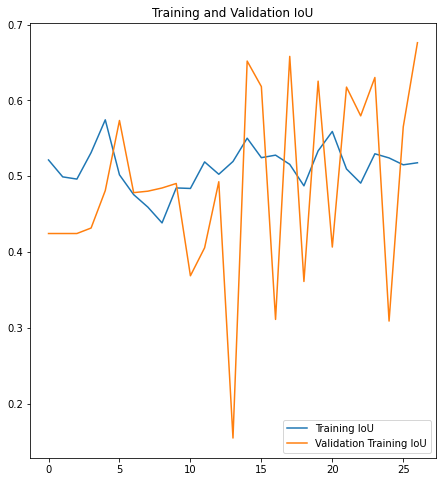

In [ ]:
IoU = history.history['updated_mean_io_u']
IoU_val = history.history['val_updated_mean_io_u']
epochs_range = range(EPOCHS-23)
print(epochs_range)
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, IoU, label='Training IoU')
plt.plot(epochs_range, IoU_val, label='Validation Training IoU')
plt.legend(loc='lower right')
plt.title('Training and Validation IoU')
plt.draw()

# 6. Predict and Validate Output
Now that our model is trained, let's predict against some sample data and compare the ground truth mask with our predicted mask.

In [ ]:
val_preds = model.predict(val_seq)

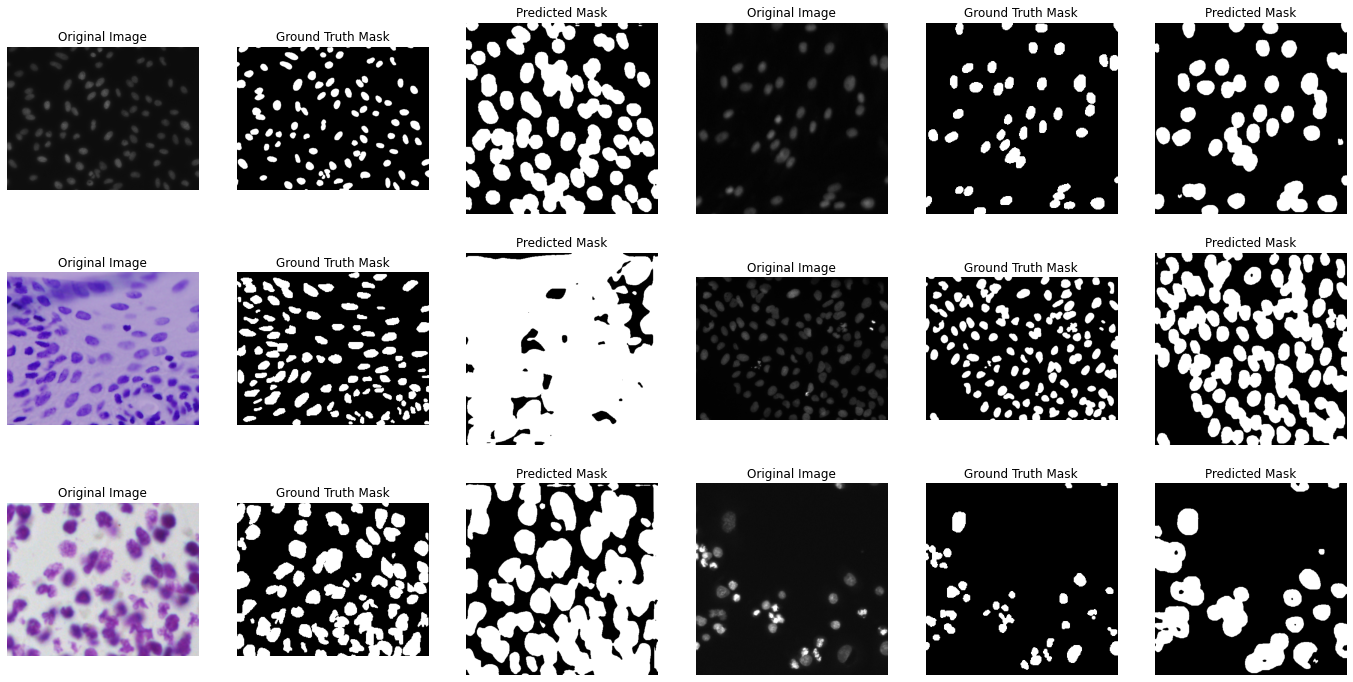

In [ ]:
# Randomly select four images from validation data
# Display input image, input mask, and predicted mask
def plot_images(image_list, mask_list, predictions, sample_size):
    i = np.random.randint(0, len(image_list)-1, size=sample_size)
    f, axarr = plt.subplots(sample_size//2, 6, figsize=(24,int(sample_size*2)))
    axarr = axarr.flatten()
    _ = [a.set_axis_off() for a in axarr.ravel()]
    for x in range(sample_size):
        axarr[3*x].imshow(load_img(image_list[i[x]]))
        axarr[3*x].set_title("Original Image")
        axarr[3*x+1].imshow(load_img(mask_list[i[x]]), cmap="gray")
        axarr[3*x+1].set_title("Ground Truth Mask")
        pred_mask = np.argmax(predictions[i[x]], axis=-1)
        pred_mask = np.expand_dims(pred_mask, axis=-1)
        pred_img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(pred_mask))
        axarr[3*x+2].imshow(pred_img, cmap="gray")
        axarr[3*x+2].set_title("Predicted Mask")

VAL_IMG_SAMPLE = 6
plot_images(val_image_list, val_masks_list, val_preds, VAL_IMG_SAMPLE)

### Utility to download TensorBoard logs to upload to TensorBoard.dev

In [ ]:
# !rm -f /kaggle/working/tensorboardlogs.tar; cd /kaggle/working; tar czf tensorboardlogs.tar.gz tensorboardlogs
# FileLink(r'tensorboardlogs.tar.gz')

###### List of Runs
* `20200802-225855`: 50 epochs, batch size 4, no augmentation, image size 256,256 
* `20200802-231718`: 50 epochs, batch size 4, no augmentation, image size 256,256
* `20200802-232838`: 50 epochs, batch size 8, no augmentation, image size 256,256
* `20200802-233711`: 50 epochs, batch size 2, no augmentation, image size 256,256
* optimal --> batch size 4
* `20200803-001835`: 50 epochs, batch size 4, no augmentation, image size 512,512
* improved --> image size 512,512
* `20200803-220200`: 50 epochs, batch size 4, no augmentation, image size 512,512, early stopping at epoch 26
* `20200803-231343`: 50 epochs, batch size 4, no augmentation, image size 512,512, early stopping at epoch 29

In [ ]:
# TESTING CODE
def plot_images2(image_list, mask_list, predictions, sample_size):
    i = np.random.randint(0, len(image_list)-1, size=sample_size)
    f, axarr = plt.subplots(sample_size//2, 6, figsize=(24,int(sample_size*2)))
    axarr = axarr.flatten()
    _ = [a.set_axis_off() for a in axarr.ravel()]
    for x in range(sample_size):
        axarr[3*x].imshow((image_list[i[x]]))
        axarr[3*x].set_title("Original Image")
        axarr[3*x+1].imshow((mask_list[i[x]][:,:,0]), cmap="gray")
        axarr[3*x+1].set_title("Ground Truth Mask")
        pred_mask = np.argmax(predictions[i[x]], axis=-1)
        pred_mask = np.expand_dims(pred_mask, axis=-1)
        pred_img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(pred_mask))
        axarr[3*x+2].imshow(pred_img, cmap="gray")
        axarr[3*x+2].set_title("Predicted Mask")

# aug_batch = next(train_gen_aug)
# t_img = aug_batch[0]
# t_msk = aug_batch[1]
# plot_images2(t_img, t_msk, model.predict(aug_batch), 6)
# plot_images2(t_img, t_msk, model.predict(aug_batch), 6)